In [1]:
import os
import numpy as np
import pandas as pd 
from time import time
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Read the data
train = pd.read_csv('higgsTrain.csv')
test = pd.read_csv('higgsTest.csv')
for col in list(train.columns):
    print(col)
print(len(list(train.columns)))

EventId
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
DER_lep_eta_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
PRI_jet_all_pt
Weight
Label
33


In [3]:
#Look at the number of jets first
train['PRI_jet_num'].value_counts()

0    99913
1    77544
2    50379
3    22164
Name: PRI_jet_num, dtype: int64

In [4]:
#Split the dataset into different jets
dfJet0 = train[(train['PRI_jet_num'] == 0)]
dfJet1 = train[(train['PRI_jet_num'] == 1)]
dfJet2 = train[(train['PRI_jet_num'] == 2)]
dfJet3 = train[(train['PRI_jet_num'] == 3)]
del train

def clean_jet_sets(jetFrame):
    for col in list(jetFrame.columns):
        missing = (jetFrame[col] == -999.000)
        if (missing.all()  == True):
            jetFrame = jetFrame.drop(col, axis = 1)
    return jetFrame

dfJet0 = clean_jet_sets(dfJet0)
dfJet1 = clean_jet_sets(dfJet1)
dfJet2 = clean_jet_sets(dfJet2)
dfJet3 = clean_jet_sets(dfJet3)

Each Jet is now considered separately and analysis performed separately. 

In [5]:
#dfJet0['PRI_jet_all_pt'].value_counts()
dfJet0 = dfJet0.drop(['PRI_jet_num','PRI_jet_all_pt'],axis = 1)
#Also, 'DER_pt_h' always equals 'DER_pt_tot':
dfJet0 = dfJet0.drop(['DER_pt_h'],axis = 1)

Due to the presence of a single jet in Jet 1, the transversal momentum equals the total

In [6]:
#(dfJet1['PRI_jet_all_pt'] - dfJet1['PRI_jet_leading_pt']).value_counts()
dfJet1 = dfJet1.drop(['PRI_jet_num','PRI_jet_all_pt'],axis = 1)

In [7]:
# For two jets, the total transversal momentum is the sum of the momentum of both jets -
#Lack of new information 
dfJet2 = dfJet2.drop(['PRI_jet_num', 'PRI_jet_all_pt'], axis = 1)
#There is more information available only when three jets are present 
dfJet3 = dfJet3.drop(['PRI_jet_num'],axis = 1)

#Since we're interested only in the sign of DER_deltaeta_jet_jet, drop it for now:
dfJet2 = dfJet2.drop('DER_deltaeta_jet_jet', axis = 1)
dfJet3 = dfJet3.drop('DER_deltaeta_jet_jet', axis = 1)

In [8]:
#Look at the missing values 
def getMissing(DF):
    for col in list(DF.columns):
        missing = (DF[col] == -999.0)
        if (missing.any() == True):
            print(col)
getMissing(dfJet0)
getMissing(dfJet1)
getMissing(dfJet2)
getMissing(dfJet3)

DER_mass_MMC
DER_mass_MMC
DER_mass_MMC
DER_mass_MMC


In [9]:
#Distribution of labels in the missing values
#After running the analysis we see that the majority of the values are in background and few in signal. 
def labelDistribution(DF):
    missing = (DF['DER_mass_MMC'] == -999.0)
    labels = DF['Label']
    print (labels[missing].value_counts())
labelDistribution(dfJet0)
labelDistribution(dfJet1)
labelDistribution(dfJet2)
labelDistribution(dfJet3)

b    24564
s     1559
Name: Label, dtype: int64
b    6857
s     705
Name: Label, dtype: int64
b    2485
s     467
Name: Label, dtype: int64
b    1373
s     104
Name: Label, dtype: int64


In [10]:
#Split the dataset by mass and no mass and change the labels to 1s and 0s
def splitByMass(jetSet):
    jetSetM = jetSet[jetSet['DER_mass_MMC'] > 0]
    jetSetnoM = jetSet[jetSet['DER_mass_MMC'] < 0]
    return jetSetM,jetSetnoM.drop(['DER_mass_MMC'],axis = 1)
dfJet0M,dfJet0NM = splitByMass(dfJet0)
dfJet1M,dfJet1NM = splitByMass(dfJet1)
dfJet2M,dfJet2NM = splitByMass(dfJet2)
dfJet3M,dfJet3NM = splitByMass(dfJet3)
def changeLabels(x):
    if x == 'b':
        return 0
    if x == 's':
        return 1
jetDFs = [dfJet0M,dfJet0NM,dfJet1M,dfJet1NM,dfJet2M,dfJet2NM,dfJet3M,dfJet3NM]
for jetDF in jetDFs:
    jetDF['Label'] = jetDF['Label'].apply(changeLabels)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Examine each feature to decide on the appropriate transformation. Using a plot of histogram for each feature

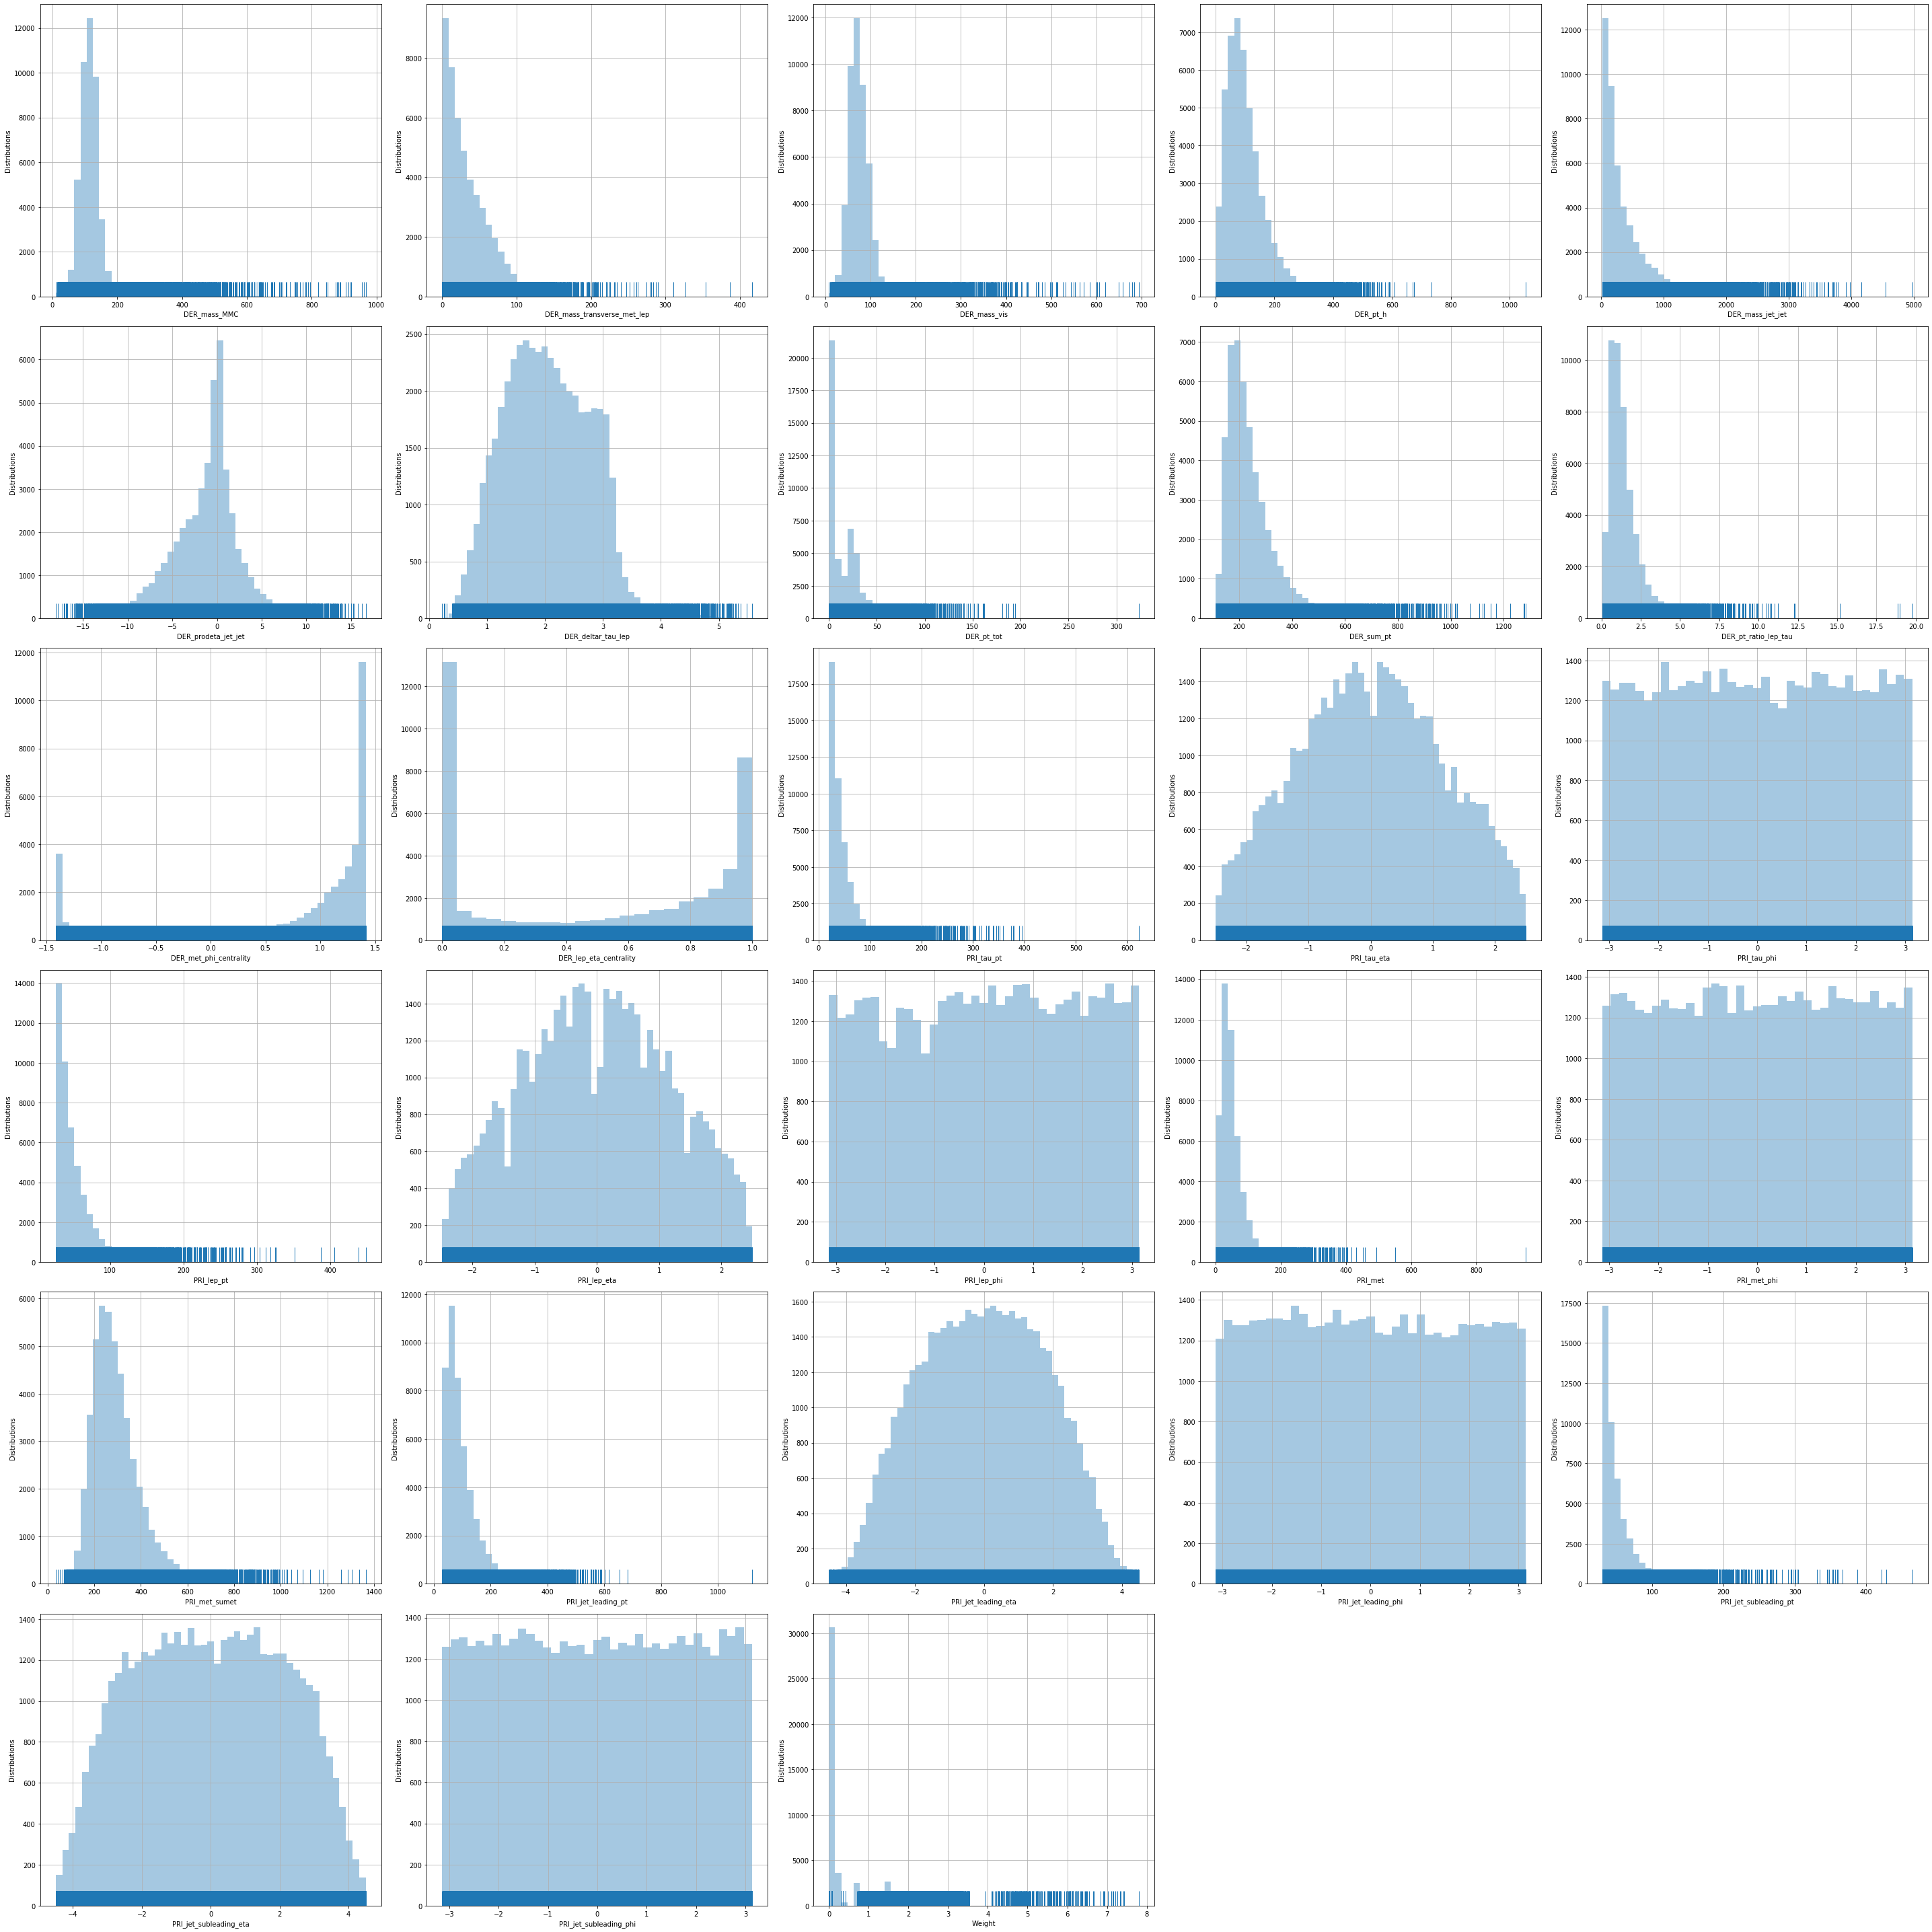

In [11]:
def plotDistributions(DF):
    plt.figure(1,figsize = (40,40))
    nrows = 6; ncols = 5
    subplotNum = 1
    for col in list(DF.columns):
        if subplotNum > len(list(DF.columns)):
            break
        if col == 'EventId' or col == 'Label':
            continue
        plt.subplot(nrows,ncols,subplotNum)
        sns.distplot(DF[col],kde = False,rug = True)
        plt.xlabel(col)
        plt.ylabel('Distributions')
        plt.grid(True)
        subplotNum += 1
    plt.tight_layout()
    plt.show()
plotDistributions(dfJet2M)   

For features that are skewed, we need to apply a logarithmic transformation and normalize the rest of them. Turn moments and weights into logarithms and normalize the non-angular data. 

In [12]:
def logMomentum(jetDF):
    #Replace the momentum with its logarithm. 
    #Add a small offset to counter the effect of log 0
    for col in list(jetDF.columns):
        if ((col.count('_phi') + col.count('eta')) == 0):
            jetDF[col+'_log'] = np.log(jetDF[col] + 1e-8)
            jetDF = jetDF.drop(col, axis = 1)
    return jetDF

def normalizeData(jetDF):
    #Normalize all non-angular data
    for col in list(jetDF.columns):
        if ((col.count('_log') + col.count('_eta')) > 0):
            mu = jetDF[col].mean()
            sigma = jetDF[col].std()
            jetDF[col] = ((jetDF[col] - mu) / sigma)
    return jetDF

def logWeights(jetDF):
    jetDF_labels = jetDF[['Weight','Label']].copy()
    jetDF_labels['logWeight'] = np.log(jetDF_labels['Weight'])
    #Remove the labels from the original dataset
    jetDF = jetDF.drop(['Weight','Label'],axis = 1)
    return jetDF,jetDF_labels

Create a number of Gaussian splits to increase the number of features for training. 

In [13]:
#Use Gaussian splits to increase the number of features 
#Support for the Normal distribution 
from scipy.stats import norm 
def gaussifyLinear(jetDF,col,nCol):
    #Gaussian splits for non-periodic data
    #Create a set of Gaussians 
    #Find supports for equal weights 
    support = [norm.ppf(float(z) / (nCol + 1)) for z in range(1, nCol+1)]
    #Widths:
    widthRatio = 2.0 * nCol
    width = [widthRatio * norm.pdf(support[i]) for i in range(0, nCol)]
    # Create columns using overlap with the normal pdf:
    for n in range(0,nCol):
        colName = col + '_' + str(n + 1)
        jetDF[colName] = ((jetDF[col] - support[n]) * width[n])
        jetDF[colName] = norm.pdf(jetDF[colName])
    return jetDF

def gaussifyAngle(jetDF,col, nCol, refAngleColumn):
    #Gaussian splits for angular data 
    #Uniformly spaced supports around the unit circle 
    support = [(2.0 * np.pi * z) / float(nCol) for z in range(0, nCol)]
    width = .4 * float(nCol)
    for n in range(0, nCol):
        colName = col + '_' + str(n + 1)
        jetDF[colName] = np.cos(jetDF[col] - jetDF[refAngleColumn] - support[n]) - 1.0
        jetDF[colName] = norm.pdf(jetDF[colName] * width)
    return jetDF.drop(col, axis = 1)

def gaussifyData(jetDF, nCol, refAngleColumn = 'PRI_tau_phi'):
    #Create Gaussian splits for linear and angular data 
    for col in list(jetDF.columns):
        if col == refAngleColumn:
            continue 
        if ((col.count('_log') + col.count('eta')) > 0):
            jetDF = gaussifyLinear(jetDF, col, nCol)
        if (col.count('_phi') > 0):
            jetDF = gaussifyAngle(jetDF, col, nCol, refAngleColumn)
    return jetDF.drop(refAngleColumn,axis = 1)

In [14]:
#Combine all Gaussian operations into a single methods 
def gaussianModelPrep(jetDF,gaussMethods,mode = 'train'):
    #Make a copy to avoid unnecssary pandas behaviours 
    jetDF_copy = jetDF.copy()
    #Isolate scoring information for scoring 
    if mode == 'train':
        jetDF_copy,jetDF_labels = logWeights(jetDF_copy)
    else:
        jetDF_labels = None
    
    #Prepare the momentum data and normalize linear data 
    jetDF_copy = logMomentum(jetDF_copy)
    jetDF_norm = normalizeData(jetDF_copy)
    
    #Gaussian convolutions 
    jetDF_norm = gaussifyData(jetDF_norm, gaussMethods)
    
    #Clear up some memory
    del jetDF_copy
    return jetDF_norm,jetDF_labels

Supervised Learning - Validation of approach
Use a simple linear regression for the log w of the weight. 

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
def simpleLinearRegression(jetDF, jetDF_labels):
    weights = jetDF_labels['logWeight'].to_numpy()
    normData = jetDF.to_numpy()
    #Index the event IDs for the data 
    index = list(jetDF_labels.index)
    X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(normData, weights, index)
    model = LinearRegression()
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    
    results = pd.DataFrame()
    results['actualWeights'] = pd.Series(data = np.exp(y_test), index = i_test)
    results['predictedWeights']   = pd.Series(data = np.exp(preds), index = i_test)
    return results 
    

In [16]:
#Linear regression using Gaussian splits 
def runGaussianLinear(jetDFs, splitNums):
    #Assume the jet sets have already been split 
    #The splitNums indicate the number of Gaussian windows used 
    compare = pd.DataFrame(columns = ['actualWeights', 'predictedWeights'])
    for jetNum in range(0, len(jetDFs)):
        print("Evaluating Jet #",jetNum,"...")
        jetDFdata,jetDFlabels = gaussianModelPrep(jetDFs[jetNum], splitNums[jetNum])
        compare = compare.append(simpleLinearRegression(jetDFdata, jetDFlabels))
    return compare 
#Include every subset 
jetDFs = [dfJet0M,dfJet0NM,dfJet1M,dfJet1NM,dfJet2M,dfJet2NM,dfJet3M,dfJet3NM]

#8-fold Gaussian splits 
splitNums = [8, 8, 8, 8, 8, 8, 8, 8]
compare = runGaussianLinear(jetDFs, splitNums)
print(compare.describe())


Evaluating Jet # 0 ...
Evaluating Jet # 1 ...
Evaluating Jet # 2 ...
Evaluating Jet # 3 ...
Evaluating Jet # 4 ...
Evaluating Jet # 5 ...
Evaluating Jet # 6 ...
Evaluating Jet # 7 ...
       actualWeights  predictedWeights
count   62503.000000      62503.000000
mean        1.645533          1.133915
std         1.876725          2.181301
min         0.001502          0.000228
25%         0.018636          0.040111
50%         1.142790          0.250902
75%         2.404005          1.361173
max         7.821961         82.893201


Let us visualize the correlation between actual and predicted weights

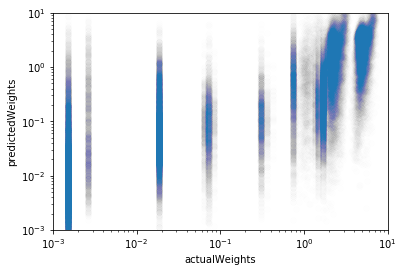

In [17]:
def plotCorrelation(col1,col2):
    plt.xlim(0.001,10.0)
    plt.ylim(0.001,10.0)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.loglog()
    plt.scatter(compare[col1], compare[col2], alpha = 0.005)
    plt.show()
plotCorrelation('actualWeights','predictedWeights')